In [2]:
%matplotlib inline

import shutil
import os
from joblib import dump, load
import urllib3
import certifi
from Bio import SeqIO
from glob import glob
import json
from IPython import display
import pandas as pd
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

![HIV genome](https://upload.wikimedia.org/wikipedia/commons/c/c6/HIV-genome.png)

In [2]:
patients = ["p{}".format(i) for i in range(1,12)]
hiv_regions = ["V3", "PR", "psi", "vpr", "vpu", "p1", "p2", "p6", "p7", "p15", "p17", "RRE"]

![HIV genome details](https://res.mdpi.com/viruses/viruses-08-00248/article_deploy/html/images/viruses-08-00248-g002.png)

In [12]:
def download_hivevo_haplotype(patient, hiv_region, folder):
    
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                               ca_certs=certifi.where())
    
    api = "https://hiv.biozentrum.unibas.ch/api/data/haplotypes/"
    
    url = "/".join((api, patient, hiv_region))

    if not os.path.isdir(folder):
        os.mkdir(folder)

    file_name = folder + "_".join(("hivevo", patient, region)) + ".fasta"

    with http.request('GET', url, preload_content=False) as res, open(file_name, 'wb') as out_file:

        shutil.copyfileobj(res, out_file)
        
folder = "data/hivevo/"
for patient in patients:
    for region in hiv_regions:
        download_hivevo_haplotype(patient, region, folder)

In [69]:
file_lst = glob(folder + "*V3.fasta")
file_lst[0], len(file_lst)

('data/hivevo/hivevo_p3_V3.fasta', 11)

In [77]:
tdf = pd.DataFrame()
for path in file_lst:
    with open(path, "r") as f:
        records = json.load(f)
    df = pd.DataFrame(records)
    df = df.drop("description", axis=1)
    df["patient"] = path.split("_")[1]
    tdf = pd.concat([tdf, df])

In [92]:
tdf.groupby("patient").agg({"days since infection" : ["min", np.median, "max", pd.Series.nunique],
                            "patient": ["size"]}).sort_index()

patient days since infection                     
           size                  min median   max nunique
patient                                                  
p1          103                  122   2639  2996      12
p10          16                   33   2229  2229       2
p11          86                  209   1026  2043       6
p2           11                   74    936  2018       5
p3           65                  146    797  3079       7
p4           67                   93   1142  3069       8
p5           68                  134   1813  2149       6
p6           36                   62   2556  2556       5
p7           97                 2369   3992  5869       8
p8          133                   87   1437  2208       7
p9           17                  106    813  2955       6

In [ ]:
tdf.columns = ["days", "frequency", "name", "sequence", "patient"]

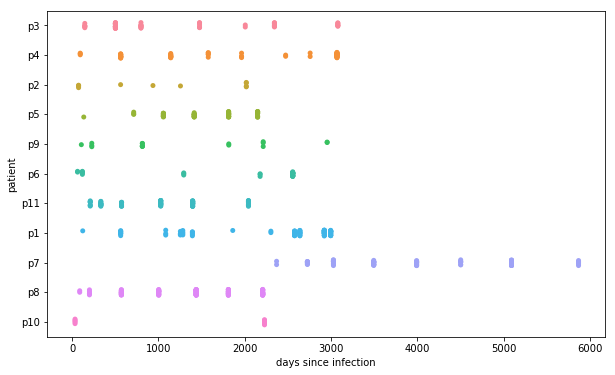

In [104]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
sns.stripplot(y="patient", x="days", data=tdf, )

I will remove p10, because there are too few time points and p7, because it's too different from other samples.

In [106]:
tdf = tdf[~tdf.patient.isin(["p7", "p10"])]
tdf.shape

(586, 5)

In [108]:
tdf.columns = ["days", "frequency", "name", "sequence", "patient"]

In [122]:
_, bin_edges = np.histogram(tdf.days.values, 5)
bin_edges[0] -= 1
bin_edges[-1] += 1
tdf["bins"] = np.digitize(tdf.days.values, bin_edges)
tdf.head()

,days,frequency,name,sequence,patient,bins
0,146,24.0,days_146_frequency_24%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,1
1,146,3.0,days_146_frequency_3%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,1
2,146,11.0,days_146_frequency_11%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,1
3,146,21.0,days_146_frequency_21%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,1
4,146,18.0,days_146_frequency_18%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,1


In [123]:
tdf.groupby(["patient", "bins"]).size().unstack(fill_value=0)

bins,1,2,3,4,5
patient,,,,,
p1,10,7,10,2,74
p11,27,19,25,15,0
p2,5,2,0,4,0
p3,32,9,6,11,7
p4,21,13,5,6,22
p5,1,17,36,14,0
p6,6,0,3,3,24
p8,32,19,56,26,0
p9,4,6,2,3,2


In [125]:
tdf = tdf.drop("bins", axis=1)
# Will analyse everyone separately

In [128]:
tdf[tdf.patient == "p4"].groupby('days').size()

days
93       3
562     18
1142    13
1577     5
1963     4
2474     2
2758     2
3069    20
dtype: int64

In [131]:
tdf = tdf.reset_index(drop=True)
tdf.loc[1, "sequence"]

'GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAGAGGTGGTCATTAGATCTGAAAATTTCACAAACAATGCTAAAACCATAATAGTACAGCTGAATGAAACTGTAGAAATTAATTGTACAAGACCCAATAACAATACAAGAAAGGGTATACATATAGGACCAGGGAGAGCATTTTATGCAACAGGAGAAATAATAGGAGATATAAGACAAGCACATTGTAACATTAGTAAAGCAAAATGGAATAACACTTTAGAAAAGATAGTTGAAAAACTAAGAGAACGATTTGAAAATAAAACAATATCCTTTAGGCCACCCTCAGGAGGGGACCTAGAAATTGTAACACACAGT'

In [159]:
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

def translate_seq(dna_sequence):
    coding_dna = Seq(dna_sequence.replace("-",""), IUPAC.ambiguous_dna)
    translated_sequence = coding_dna.translate(gap='-')
    return str(translated_sequence)
    
ts = translate_seq(tdf.loc[1, "sequence"])
ts

'VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRPNNNTRKGIHIGPGRAFYATGEIIGDIRQAHCNISKAKWNNTLEKIVEKLRERFENKTISFRPPSGGDLEIVTHS'

In [160]:
tdf["aa_seq"] = tdf.sequence.apply(translate_seq)
tdf.head()

/home/vcvetkov/anaconda3/lib/python3.5/site-packages/Bio/Seq.py:2095: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


,days,frequency,name,sequence,patient,aa_seq,is_gapped
0,146,24.0,days_146_frequency_24%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,no
1,146,3.0,days_146_frequency_3%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,no
2,146,11.0,days_146_frequency_11%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,no
3,146,21.0,days_146_frequency_21%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNKTVEINCTRP...,no
4,146,18.0,days_146_frequency_18%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,no


In [174]:
tdf["is_partial"] = tdf.sequence.apply(lambda x: 1 if len(x)%3!=0 else 0)
tdf[tdf.is_partial == 1].reset_index(drop=True).loc[2, "aa_seq"]

'VVSTQLLLNGSLAEEEIVIRSENFTNNAKTIIVQLNETVQIYCVRPNNNTRRSIHIAPGRAFYATGEIIGDIRQAHCNISKVNWTNTLRKIKDKLKEQFNNTKIVFNHSSGGDPEIVMHS'

In [172]:
tdf["stop_codon"] = tdf.aa_seq.apply(lambda x: 1 if "*" in x else 0)
tdf[tdf.stop_codon == 1].shape

(15, 8)

In [177]:
NewAAFactors = pd.read_csv("modules/NewAAFactors.csv", index_col=0)

fts = ['ft1', 'ft2', 'ft3', 'ft4', 'ft5']

def score_factors(sequence, norm=False):
    if norm:
        return NewAAFactors.loc[list(sequence)].sum() / len(sequence)
    else:
        return NewAAFactors.loc[list(sequence)].sum()
    
NewAAFactors.head()

,ft1,ft2,ft3,ft4,ft5
A,-0.571872,-0.258294,-0.019812,-0.385102,-0.227171
C,0.074914,0.223311,-0.038913,0.165558,-0.183481
D,-0.067988,-0.123953,-0.281683,-0.081865,0.068827
E,0.179362,0.166592,-0.270101,0.150409,-0.330397
F,0.108482,-0.102651,0.123098,-0.458819,-0.240836


In [180]:
ndf = pd.concat([tdf[tdf.stop_codon==0], tdf[tdf.stop_codon==0].aa_seq.apply(lambda s: score_factors(s))], axis=1)
ndf = ndf.reset_index(drop=True)
ndf.head()

,days,frequency,name,sequence,patient,aa_seq,stop_codon,is_partial,ft1,ft2,ft3,ft4,ft5
0,146,24.0,days_146_frequency_24%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,0,0,3.588506,-4.919609,-3.651676,-0.335010,2.517795
1,146,3.0,days_146_frequency_3%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,0,0,3.318385,-4.935150,-4.298921,-0.267687,2.125397
2,146,11.0,days_146_frequency_11%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,0,0,3.925040,-5.168366,-3.567523,-0.845607,2.782849
3,501,5.0,days_501_frequency_5%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,0,0,2.472024,-5.384456,-3.062401,-0.849992,2.362270
4,501,2.0,days_501_frequency_2%,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,p3,VVSTQLLLNGSLAEEEVVIRSENFTNNAKTIIVQLNETVEINCTRP...,0,0,2.472024,-5.384456,-3.062401,-0.849992,2.362270


In [187]:
fts = ['ft1', 'ft2', 'ft3', 'ft4', 'ft5']
res = ndf.groupby(['patient', "days"]).agg(OrderedDict((ft,[np.mean]) for ft in fts))
res.columns = res.columns.droplevel(1)
res

ft1       ft2       ft3       ft4       ft5
patient days                                                  
p1      122   3.444482 -6.599587 -4.275062  0.729689  2.204719
        562   3.573930 -6.790132 -4.258903  0.390979  2.362934
        1084  4.114685 -6.951708 -4.159371  0.193828  2.292599
        1254  4.415844 -6.847503 -4.372068 -0.004431  1.580871
        1282  4.810229 -6.742054 -4.400126 -0.142189  1.728422
        1393  4.951047 -6.352707 -4.465801 -0.302113  1.650003
        1861  2.414024 -5.451309 -4.531362  1.123664  2.204761
        2303  0.945365 -3.988139 -4.641353  1.049295  4.320711
        2578  3.030238 -4.850060 -3.790865  0.142597  4.004060
        2639  3.009471 -4.961433 -3.911621  0.293764  3.395520
        2922  2.929727 -4.793522 -3.946559  0.956910  3.912595
        2996  2.899827 -4.723025 -4.017590  0.940132  3.981742
p11     209   3.656234 -4.602864 -2.995568 -0.870884  4.329750
        332   3.910435 -4.388630 -2.951865 -0.900992  4.238068
        572   3.504396 -4.230362 -3.213715 -0.890862  3.986956
        1026  4.061649 -4.269569 -3.441146 -0.933746  4.167885
        1396  5.085101 -4.024151 -3.313329 -0.475523  4.608307
        2043  6.077168 -4.615415 -3.176553 -1.164422  4.522042
p2      74    2.870748 -6.653428 -1.669409 -2.169239  3.681443
        561   3.798684 -6.983641 -1.743519 -2.407351  3.855149
        936   3.699507 -6.213526 -2.001037 -1.419725  3.946610
        1255  3.092431 -6.356998 -1.794512 -2.099031  3.368439
        2018  1.774038 -6.942501 -1.650242 -2.297648  2.757934
p3      146   3.689243 -5.047873 -3.771411 -0.573478  2.552222
        501   3.749501 -5.361409 -3.525855 -1.060810  2.965380
        797   2.929691 -4.963030 -3.570349 -0.000800  3.099685
        1476  3.881725 -4.947027 -4.172388 -0.098216  3.510072
        2006  3.678886 -6.815910 -4.098063  0.366891  3.806279
        2344  3.312166 -5.417807 -4.658139 -0.016268  3.911867
        3079  2.827479 -5.327793 -5.226062  0.589815  4.202699
...                ...       ...       ...       ...       ...
p4      1142  3.736539 -5.994767 -2.635944 -1.546295  1.573739
        1577  4.213105 -6.188275 -2.399831 -1.619603  3.179750
        1963  3.800355 -6.757673 -3.451363 -1.484495  1.082582
        2474  2.848432 -6.983256 -1.888836 -0.646057  4.240109
        2758  3.880190 -6.645947 -2.129977 -2.460125  4.432911
        3069  3.167406 -6.102062 -3.762172 -1.997110  2.249426
p5      134   3.523403 -6.932884 -1.695466 -1.920105  3.949456
        713   4.268081 -6.773380 -2.152828 -0.477312  4.247493
        1057  3.838156 -6.988175 -1.593428 -0.583289  4.497375
        1414  3.930904 -7.352457 -1.892792 -0.330058  3.724489
        1813  2.993606 -7.063927 -1.445325 -0.200548  4.461902
        2149  4.204992 -6.662057 -2.138534 -0.700850  4.803029
p6      62    1.582798 -5.777547  0.301077  1.222278  5.256759
        118   1.588345 -5.340519  0.057257  1.205428  4.907014
        1293  1.223224 -4.072685  1.053617  2.094898  5.962351
        2178  1.033689 -4.389736  0.516685  1.877802  5.965407
        2556  1.028796 -4.836110  0.453391  1.231910  5.933685
p8      87    1.873119 -5.534398 -2.326913 -0.009506  4.344552
        200   1.990539 -5.846423 -1.935833 -0.078701  4.451332
        570   2.326840 -6.091961 -1.512838 -0.268482  5.010462
        1003  2.772083 -6.521396 -2.064965 -0.643564  5.091498
        1437  2.740084 -6.145945 -2.660402 -0.576520  5.046817
        1810  2.474796 -6.060216 -2.933732 -0.099725  4.746422
        2208  1.834025 -5.965177 -2.496355 -0.033829  5.724315
p9      106   3.241410 -4.046480 -2.208875 -1.230304  3.689962
        227   1.588675 -3.625293 -2.015726  0.407205  2.845696
        813   2.422162 -3.488282 -1.922415  0.474313  3.509981
        1815  2.409532 -3.408169 -1.907881 -1.220839  2.632444
        2214  2.037936 -3.982457 -2.095348 -0.343111  4.884325
        2955  3.555803 -1.784743 -1.705697 -1.052971  6.491930

[62 rows x 5 columns]

In [198]:
p1 = res.loc['p1',:,:]
p1.index = p1.index.droplevel(0)
p1.reset_index()

,days,ft1,ft2,ft3,ft4,ft5
0,122,3.444482,-6.599587,-4.275062,0.729689,2.204719
1,562,3.573930,-6.790132,-4.258903,0.390979,2.362934
2,1084,4.114685,-6.951708,-4.159371,0.193828,2.292599
3,1254,4.415844,-6.847503,-4.372068,-0.004431,1.580871
4,1282,4.810229,-6.742054,-4.400126,-0.142189,1.728422
5,1393,4.951047,-6.352707,-4.465801,-0.302113,1.650003
6,1861,2.414024,-5.451309,-4.531362,1.123664,2.204761
7,2303,0.945365,-3.988139,-4.641353,1.049295,4.320711
8,2578,3.030238,-4.850060,-3.790865,0.142597,4.004060
9,2639,3.009471,-4.961433,-3.911621,0.293764,3.395520


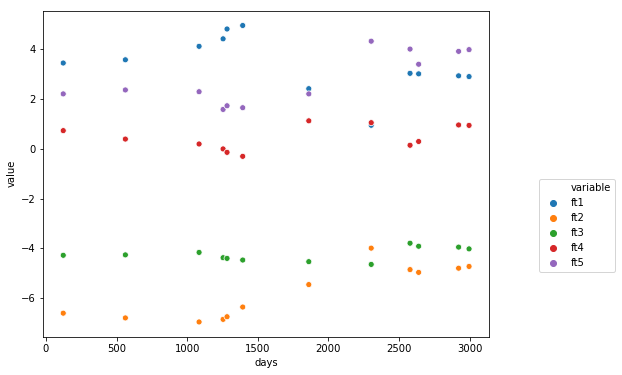

In [207]:
r = res.reset_index()
r = r[r.patient == "p1"]
r = r.drop("patient", axis=1)
rm = pd.melt(r, id_vars="days", value_vars=fts)
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x="days", y="value", hue="variable", data=rm)
plt.legend(bbox_to_anchor=(1.1, .5))

In [213]:
ndf.to_csv("data/")

In [ ]:
ndf = pd.read_csv("data/hivevo_V3_fts.csv")
clf = load("modules/hum_clf.jl")

In [ ]:
ndf.head()